## Monolingual Named Entity Recognition (Bio NLP 2004 Dataset)

Dataset Source: https://huggingface.co/datasets/tner/bionlp2004

#### Install Necessary Libraries

In [1]:
#%pip install transformers datasets evaluate seqeval

#### Import Necessary Libraries

In [30]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np

import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.nn.functional import cross_entropy

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [31]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Pandas :".rjust(18), pd.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Evaluate :".rjust(18), evaluate.__version__)
print("Sklearn :".rjust(18), sklearn.__version__)

          Python : 3.9.12
           NumPy : 1.24.3
          Pandas : 2.0.1
           Torch : 2.0.0
    Transformers : 4.28.1
        Datasets : 2.11.0
        Evaluate : 0.4.0
         Sklearn : 1.2.2


#### Ingest English Subset of Dataset

In [4]:
data = load_dataset("tner/bionlp2004")

data

Found cached dataset bionlp2004 (/Users/briandunn/.cache/huggingface/datasets/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 16619
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1927
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 3856
    })
})

#### Example

In [5]:
example = data['train'][12]

example

{'tokens': ['The',
  'transcription',
  'factor',
  'nuclear',
  'factor-kappa',
  'B',
  '(',
  'NF-kappa',
  'B',
  ')',
  'is',
  'critical',
  'for',
  'the',
  'inducible',
  'expression',
  'of',
  'multiple',
  'cellular',
  'and',
  'viral',
  'genes',
  'involved',
  'in',
  'inflammation',
  'and',
  'infection',
  'including',
  'interleukin-1',
  '(',
  'IL-1',
  ')',
  ',',
  'IL-6',
  ',',
  'and',
  'adhesion',
  'molecules',
  '.'],
 'tags': [0,
  3,
  4,
  3,
  4,
  4,
  0,
  3,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  3,
  0,
  0,
  3,
  0,
  0,
  3,
  4,
  0]}

#### Display Feature Information About Each Feature

In [6]:
for k, v in data["train"].features.items():
    print(f"{k}: \n{v}\n")

tokens: 
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

tags: 
Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)



#### Define Tag Values & Conversions Between String & Integer Values

In [7]:
label2id = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

id2label = {tag: idx for idx, tag in label2id.items()}

tags = list(label2id.keys())

NUM_OF_LABELS = len(tags)

print(f"List of tag values: \n{tags}")
print(f"id2label: \n{id2label}")
print(f"label2id: \n{label2id}")
print(f"Number of NER Tags: {NUM_OF_LABELS}")

List of tag values: 
['O', 'B-DNA', 'I-DNA', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA']
id2label: 
{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}
label2id: 
{'O': 0, 'B-DNA': 1, 'I-DNA': 2, 'B-protein': 3, 'I-protein': 4, 'B-cell_type': 5, 'I-cell_type': 6, 'B-cell_line': 7, 'I-cell_line': 8, 'B-RNA': 9, 'I-RNA': 10}
Number of NER Tags: 11


#### Basic Values/Constants

In [8]:
MODEL_CKPT = "bert-base-cased"

MODEL_NAME = f"{MODEL_CKPT}-finetuned-ner-bio_nlp_2004"
NUM_OF_EPOCHS = 3

BATCH_SIZE = 16
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
WEIGHT_DECAY = 0.01

LR = 2e-5
DEVICE = torch.device("cpu")

STEPS = 100

#### Function to Tokenize & Align Inputs

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_and_align_labels(samples):
    tokenized_inputs = tokenizer(samples["tokens"], 
                                      truncation=True, 
                                      is_split_into_words=True)
    
    labels = []
    
    for idx, label in enumerate(samples[f"tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids: # set special tokens to -100
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### Apply Above Function to Tokenize Dataset

In [10]:
encoded_ds = data.map(tokenize_and_align_labels, 
                       batched=True, 
                       remove_columns=
                        [
                            'tags', 
                            'tokens'
                        ]
                    )

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904/cache-d1705a21fa18271d.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904/cache-e035560a4a5185b0.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904/cache-f0e4067f0b6b1413.arrow


#### Define Data Collator

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### Load Custom Model

In [12]:
model = (AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

#### Create Compute Metrics Function

In [13]:
label_list = tags

print(label_list)

['O', 'B-DNA', 'I-DNA', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA']


In [14]:
seqeval = evaluate.load("seqeval")

labels = [tags[i] for i in example[f"tags"]]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, 
                            axis=2)
    
    true_predictions = [
        [tags[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [tags[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(predictions=true_predictions, 
                              references=true_labels)
    
    return results

#### Define TrainingArguments

In [15]:
args = TrainingArguments(
    MODEL_NAME,
    log_level="error",
    logging_first_step=True,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [16]:
trainer = Trainer(model, 
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["test"]
                  )

Cloning https://huggingface.co/DunnBC22/bert-base-cased-finetuned-ner-bio_nlp_2004 into local empty directory.


#### Train Model

In [17]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3117 [00:00<?, ?it/s]

{'loss': 2.4176, 'learning_rate': 1.999358357394931e-05, 'epoch': 0.0}
{'loss': 0.583, 'learning_rate': 1.9358357394931026e-05, 'epoch': 0.1}
{'loss': 0.2819, 'learning_rate': 1.871671478986205e-05, 'epoch': 0.19}
{'loss': 0.2311, 'learning_rate': 1.807507218479307e-05, 'epoch': 0.29}
{'loss': 0.2207, 'learning_rate': 1.7433429579724095e-05, 'epoch': 0.38}
{'loss': 0.1981, 'learning_rate': 1.679178697465512e-05, 'epoch': 0.48}
{'loss': 0.1998, 'learning_rate': 1.6150144369586143e-05, 'epoch': 0.58}
{'loss': 0.1983, 'learning_rate': 1.5508501764517164e-05, 'epoch': 0.67}
{'loss': 0.1839, 'learning_rate': 1.4866859159448189e-05, 'epoch': 0.77}
{'loss': 0.1834, 'learning_rate': 1.4225216554379211e-05, 'epoch': 0.87}
{'loss': 0.1701, 'learning_rate': 1.3583573949310235e-05, 'epoch': 0.96}


  0%|          | 0/241 [00:00<?, ?it/s]

{'eval_loss': 0.19273489713668823, 'eval_DNA': {'precision': 0.6152610441767068, 'recall': 0.7253787878787878, 'f1': 0.6657974793568013, 'number': 1056}, 'eval_RNA': {'precision': 0.6616541353383458, 'recall': 0.7457627118644068, 'f1': 0.7011952191235059, 'number': 118}, 'eval_cell_line': {'precision': 0.46697388632872505, 'recall': 0.608, 'f1': 0.5282363162467419, 'number': 500}, 'eval_cell_type': {'precision': 0.6997455470737913, 'recall': 0.7157730348776679, 'f1': 0.7076685537828101, 'number': 1921}, 'eval_protein': {'precision': 0.6602894693062719, 'recall': 0.783303730017762, 'f1': 0.716555334897996, 'number': 5067}, 'eval_overall_precision': 0.6498750624687656, 'eval_overall_recall': 0.7506349572846918, 'eval_overall_f1': 0.6966304173139766, 'eval_overall_accuracy': 0.9352316478121876, 'eval_runtime': 382.8236, 'eval_samples_per_second': 10.073, 'eval_steps_per_second': 0.63, 'epoch': 1.0}
{'loss': 0.161, 'learning_rate': 1.294193134424126e-05, 'epoch': 1.06}
{'loss': 0.1474, 'le

  0%|          | 0/241 [00:00<?, ?it/s]

{'eval_loss': 0.1981300711631775, 'eval_DNA': {'precision': 0.6364372469635627, 'recall': 0.7443181818181818, 'f1': 0.6861632474901789, 'number': 1056}, 'eval_RNA': {'precision': 0.6408450704225352, 'recall': 0.7711864406779662, 'f1': 0.7000000000000002, 'number': 118}, 'eval_cell_line': {'precision': 0.4606896551724138, 'recall': 0.668, 'f1': 0.5453061224489797, 'number': 500}, 'eval_cell_type': {'precision': 0.7375615090213231, 'recall': 0.7022384174908901, 'f1': 0.7194666666666666, 'number': 1921}, 'eval_protein': {'precision': 0.6758880340481257, 'recall': 0.8148805999605289, 'f1': 0.7389047959914101, 'number': 5067}, 'eval_overall_precision': 0.6662350597609562, 'eval_overall_recall': 0.7722235049642115, 'eval_overall_f1': 0.7153245642177307, 'eval_overall_accuracy': 0.9364193315320131, 'eval_runtime': 416.2901, 'eval_samples_per_second': 9.263, 'eval_steps_per_second': 0.579, 'epoch': 2.0}
{'loss': 0.1378, 'learning_rate': 6.525505293551493e-06, 'epoch': 2.02}
{'loss': 0.1224, 'l

  0%|          | 0/241 [00:00<?, ?it/s]

{'eval_loss': 0.20655187964439392, 'eval_DNA': {'precision': 0.6619127516778524, 'recall': 0.7471590909090909, 'f1': 0.7019572953736656, 'number': 1056}, 'eval_RNA': {'precision': 0.589041095890411, 'recall': 0.7288135593220338, 'f1': 0.6515151515151515, 'number': 118}, 'eval_cell_line': {'precision': 0.4758522727272727, 'recall': 0.67, 'f1': 0.5564784053156145, 'number': 500}, 'eval_cell_type': {'precision': 0.7294117647058823, 'recall': 0.7100468505986466, 'f1': 0.7195990503824848, 'number': 1921}, 'eval_protein': {'precision': 0.6657656225155033, 'recall': 0.8263272153147819, 'f1': 0.7374075378654457, 'number': 5067}, 'eval_overall_precision': 0.6627781590040193, 'eval_overall_recall': 0.7805356730547218, 'eval_overall_f1': 0.71685309865875, 'eval_overall_accuracy': 0.936745944554965, 'eval_runtime': 406.1352, 'eval_samples_per_second': 9.494, 'eval_steps_per_second': 0.593, 'epoch': 3.0}
{'train_runtime': 22380.9714, 'train_samples_per_second': 2.228, 'train_steps_per_second': 0.13

#### Push Model To Hub

In [18]:
kwargs = {
    "tasks": "token-classification",
    "tags": ['token-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('All DUNN!!!', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/411M [00:00<?, ?B/s]

Upload file runs/Jul03_23-31-49_Brians-Mac-mini.local/events.out.tfevents.1688445114.Brians-Mac-mini.local.108…

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-ner-bio_nlp_2004
   63275fa..2863a28  main -> main

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-ner-bio_nlp_2004
   2863a28..bc39d78  main -> main



#### Save & Log Model

In [19]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-ner-bio_nlp_2004
   bc39d78..385a0ed  main -> main



***** train metrics *****
  epoch                    =        3.0
  train_loss               =     0.1688
  train_runtime            = 6:13:00.97
  train_samples_per_second =      2.228
  train_steps_per_second   =      0.139


### Error Analysis

#### Define Method to Apply to Validation Dataset (& Then Apply it)

In [23]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, 
                               attention_mask
                               )
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, 
                                       axis=-1
                                       ).cpu().numpy()
        
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 11), 
                         labels.view(-1), 
                         reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

#### Apply Above Function to Entire Evaluation Dataset

In [24]:
eval_set = encoded_ds['validation']

eval_set = eval_set.map(forward_pass_with_label,
                        batched=True,
                        batch_size=32)

eval_df = eval_set.to_pandas()

Map:   0%|          | 0/1927 [00:00<?, ? examples/s]

#### Clean Up Padding Tokens

In [25]:
id2label[-100] = "IGN"
eval_df["input_tokens"] = eval_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
eval_df["predicted_label"] = eval_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
eval_df["labels"] = eval_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
eval_df['loss'] = eval_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
eval_df['predicted_label'] = eval_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
eval_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 15393, 118, 123, 5565, 2838, 1105, 151, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, B-DNA, IGN, IGN, I-DNA, O, O, B-protein,...","[0.0, 1.0764759, 0.0, 0.0, 0.9523054, 0.000231...","[O, B-protein, O, I-DNA, O, O, O, B-protein, I...","[[CLS], IL, -, 2, gene, expression, and, N, ##..."


#### Unwrap Each Token Within Sample Separately

In [26]:
eval_df_tokens = eval_df.apply(pd.Series.explode)
eval_df_tokens = eval_df_tokens.query("labels != 'IGN'")
eval_df_tokens["loss"] = eval_df_tokens["loss"].astype(float).round(2)
eval_df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,15393,0,1,B-DNA,1.08,B-protein,IL
0,5565,0,1,I-DNA,0.95,O,gene
0,2838,0,1,O,0.00,O,expression
0,1105,0,1,O,0.00,O,and
0,151,0,1,B-protein,0.01,B-protein,N
0,139,0,1,I-protein,0.01,I-protein,B
0,14915,0,1,O,0.00,O,activation


#### See Which Tokens Have Accumulated Most Loss in Evaluation Dataset

In [27]:
(
    eval_df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(3)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,T,cells,B,E,P,(,),",",and,N
count,604,605,622,252,227,736,736,1823,1321,419
mean,0.476,0.394,0.373,0.622,0.67,0.199,0.199,0.079,0.103,0.303
sum,287.66,238.29,231.81,156.78,152.09,146.79,146.66,144.54,136.42,127.13


#### See Which Label IDs Have Most Loss in Evaluation Dataset

In [28]:
(
    eval_df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(3)
    .fillna(0)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10
labels,B-cell_type,B-DNA,B-RNA,I-cell_line,B-cell_line,I-cell_type,I-RNA,I-DNA,B-protein,I-protein,O
count,628,1260,131,940,505,696,189,2100,3029,2743,38603
mean,0.639,0.586,0.554,0.544,0.515,0.376,0.373,0.366,0.356,0.321,0.081
sum,401.09,738.1,72.52,510.92,259.91,261.98,70.46,768.54,1079.32,880.98,3123.59


#### Create Function to Display Confusion Matrix

In [35]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

#### Display Confusion Matrix

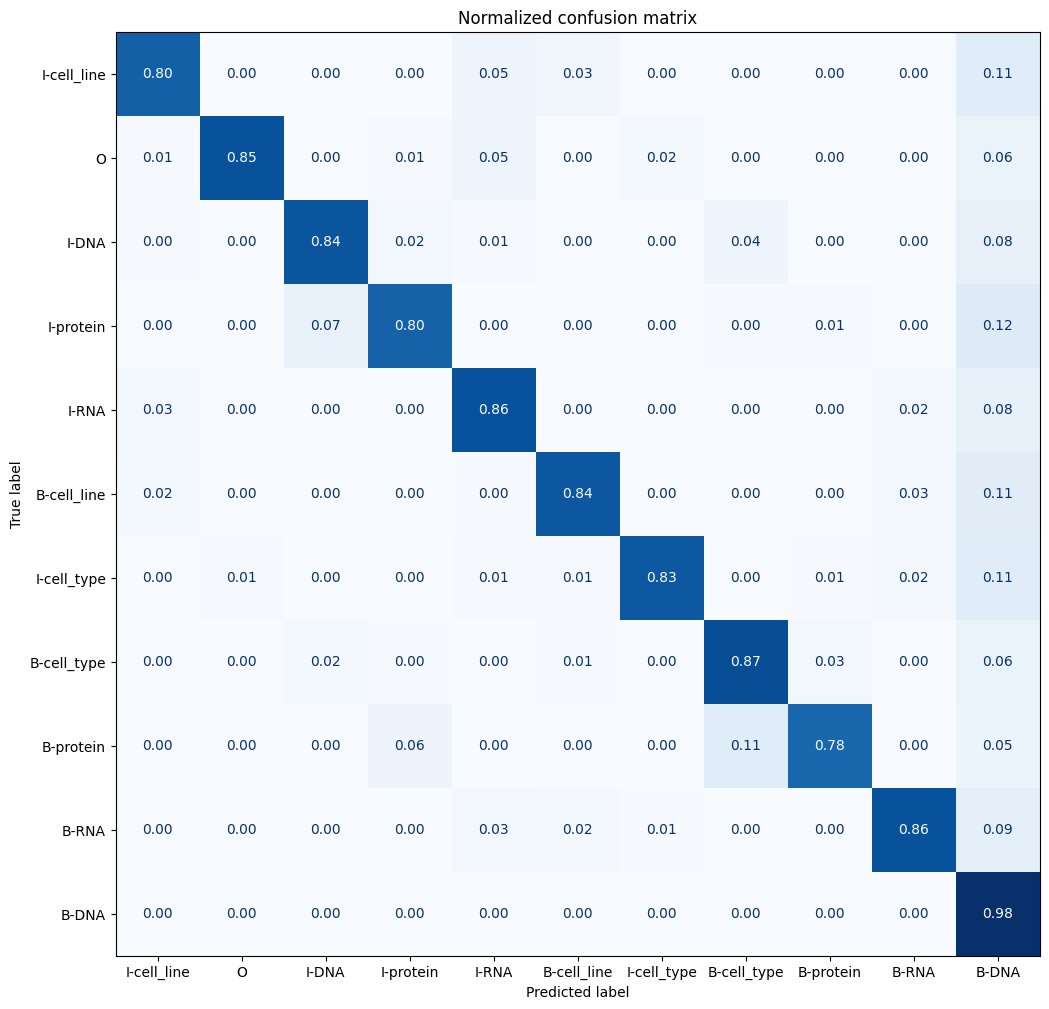

In [36]:
eval_token_list = list(set(eval_df_tokens['labels']))

plot_confusion_matrix(eval_df_tokens["labels"], eval_df_tokens["predicted_label"],
                      eval_token_list)

### Notes & Other Takeaways From This Project

****
- It looks like the model overpredicted B-DNA tokens in this model. Also, it looks like the model confused B-Protein tokens for B-Cell Type's.

****

### Citations

- Model Checkpoint

    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset

    > @inproceedings{collier-kim-2004-introduction, title = "Introduction to the Bio-entity Recognition Task at {JNLPBA}", author = "Collier, Nigel and Kim, Jin-Dong", booktitle = "Proceedings of the International Joint Workshop on Natural Language Processing in Biomedicine and its Applications ({NLPBA}/{B}io{NLP})", month = aug # " 28th and 29th", year = "2004", address = "Geneva, Switzerland", publisher = "COLING", url = "https://aclanthology.org/W04-1213", pages = "73--78",}

- Metric (SeqEval)

    > @inproceedings{ramshaw-marcus-1995-text, title = "Text Chunking using Transformation-Based Learning", author = "Ramshaw, Lance and Marcus, Mitch", booktitle = "Third Workshop on Very Large Corpora", year = "1995", url = "https://www.aclweb.org/anthology/W95-0107",}
    
    > @misc{seqeval, title={{seqeval}: A Python framework for sequence labeling evaluation}, url={https://github.com/chakki-works/seqeval}, note={Software available from https://github.com/chakki-works/seqeval}, author={Hiroki Nakayama}, year={2018},}